In [1]:
import math
import os

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
az.rcParams["stats.hdi_prob"] = 0.89
az.style.use("arviz-darkgrid")

import numpy as np
import pandas as pd

import jax.numpy as jnp
from jax import ops, random, vmap, lax
from jax.scipy.special import expit, logsumexp

import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import print_summary
from numpyro.distributions import constraints
from numpyro.infer import MCMC, NUTS, init_to_value, Predictive

numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)
plt.style.use('ggplot')

- mamy duzo obserwacji, więc przyjrzymy się pełnej części zbioru (ale warto pomyslec nad powodami czemu gdzieś mogą być braki potem jeszcze by uzupelnić coś)
- między modelami przyjrzymy się niepwnościom dla kilku 50 niedafultowym i 50 defaultowym
- dla uproszczenia ignorujemy fakt ze niektorzy klienci są rejestrowani w kilku latach i mamy o nich wieksza historie kredytową

In [2]:
df = pd.read_csv('data/full_case.csv', index_col=0)

# Preprocessing variables

Procedure for value standarization:
- because we are dealing with very large values we want to take the logarithms of them
- additionaly after checking the ranges of values I have decided to divide all values by a milion before taking the logarithmic in all columns except for those in Val_XX = [7, 15, 27, 33, 35, 37]
- because there are at the same time large positive and negative values I preprocess values in each column by adding absolute value of smallest observation and add 0.1 to avoid problem with logarithm of 0
- after all of this that standard z standarization

I most likely wont use all the values, gonna try to select potentialy interesting ones just for testing some hipotheses

In [3]:
def preprocess_data(df):
    for col in df.select_dtypes(include=["float"]).columns:
        df[col] = df[col] / 10e6
        df[col] = df[col] + abs(df[col].min()) + 1
        df[col] = np.log(df[col])
        df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

df_std = df.copy()
df_std = (df_std.pipe(preprocess_data))

Imortant to note is that representation of many histograms is still broken due to floating point problems. For example when we take the case of Var_05, there happen to be large outliers that make the visualisation stage problematic

/tmp/ipykernel_6201/4138126477.py:4: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


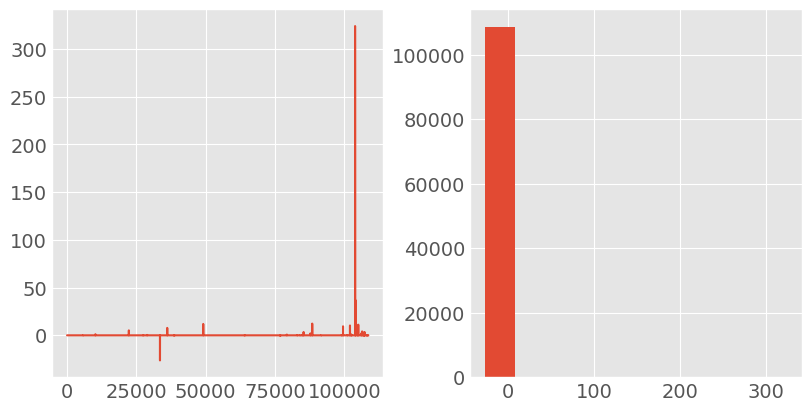

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(df_std.iloc[:, 6])
ax[1].hist(df_std.iloc[:, 6])
fig.tight_layout()

# Modeling
## Probability of default and the effect of gross profit

Lets assume that the probability that the client defaults is independent of his year to year performance, we matter is only current year. I will explore some models to gain insights into the causal structure.

Necesseray to create a uniqe identifier for each client and date combination.

W sumie moge dodać element związany z rokiem jako dwie zmienne indeksowane jedna klient druga rok, tylko ten rok problematyczny jest, moze byc za malo czesu by nad tym myśleć

In [6]:
client = pd.Categorical(df_std['ID'].astype('str') + '_' + df_std['obs_date'].astype('str'))
dlist = dict(
    gross_profit = df_std.iloc[:, 15].values,
    client = client.codes,
    default = df_std.default.values
)

In [7]:
def model1(gross_profit, client, default):
    alpha = numpyro.sample('a', dist.Normal(0, 1))
    beta = numpyro.sample('b', dist.Normal(0, 1))

    logit_p = numpyro.deterministic('p_default', alpha + beta*gross_profit)

    numpyro.sample('default', dist.Binomial(1, logits=logit_p), obs=default)

m1 = MCMC(NUTS(model1), num_samples=1000, num_chains=4, num_warmup=500)
m1.run(random.PRNGKey(0), **dlist)
m1.print_summary()

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -2.79      0.01     -2.79     -2.81     -2.77   3084.09      1.00
         b      0.08      0.01      0.08      0.07      0.10   4053.85      1.00

Number of divergences: 0


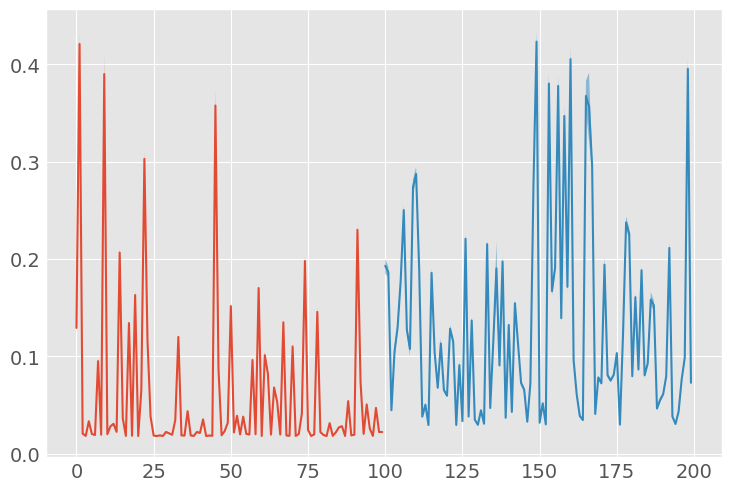

In [5]:
n = 100
ones_indices = np.random.choice(np.where(dlist['default'] == 1)[0], size=n, replace=False)
zeros_indices = np.random.choice(np.where(dlist['default'] == 0)[0], size=n, replace=False)

samples = m1.get_samples()

x = np.arange(0, n)
p_nd = expit(samples['p_default'][:, zeros_indices])
p_nd_mean = p_nd.mean(0)
p_nd_hdi = numpyro.diagnostics.hpdi(p_nd)


plt.plot(x, p_nd_mean)
plt.fill_between(x, p_nd_hdi[0, :], p_nd_hdi[1, :], alpha=.5)

x = np.arange(n, n+n)
p_d = expit(samples['p_default'][:, ones_indices])
p_d_mean = p_d.mean(0)
p_d_hdi = numpyro.diagnostics.hpdi(p_d)


plt.plot(x, p_d_mean)
plt.fill_between(x, p_d_hdi[0, :], p_d_hdi[1, :], alpha=.5)


Just gross profit is too little infromation 

## 4 variable model

In [4]:
dlist = dict(
    gross_profit = df_std.iloc[:, 15].values,
    ravenues = df_std.iloc[:, 30].values,
    assets_total = df_std.iloc[:, 3].values,
    eq_liab_total = df_std.iloc[:, 11].values,
    default = df_std.default.values
)

def model2(gross_profit, ravenues, assets_total, eq_liab_total, default):
    alpha = numpyro.sample('a', dist.Normal(0, 1))
    b1 = numpyro.sample('b1', dist.Normal(0, 1))
    b2 = numpyro.sample('b2', dist.Normal(0, 1))
    b3 = numpyro.sample('b3', dist.Normal(0, 1))
    b4 = numpyro.sample('b4', dist.Normal(0, 1))

    logit_p = numpyro.deterministic(
        'p_default', 
        alpha 
        + b1 * gross_profit
        + b2 * ravenues
        + b3 * assets_total
        + b4 * eq_liab_total
    )

    numpyro.sample('default', dist.Binomial(1, logits=logit_p), obs=default)

m1 = MCMC(NUTS(model2), num_samples=1000, num_chains=4, num_warmup=500)
m1.run(random.PRNGKey(0), **dlist)
#m1.print_summary()

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]